# Классификатор текста на базе LLM

## Задача

Используя библиотеку Transformers постороить классификаторы текста, основанных на предобученных моделях LLM: [GPT2](https://huggingface.co/ai-forever/rugpt3small_based_on_gpt2) и [BERT](https://huggingface.co/ai-forever/ruBert-base). Обе модели имеют соизмеримое количество параметров (GPT - 125M; BERT - 178M).  
Оценить результаты работы получившихся классификаторов в задаче определения настроения текста.

## Данные

Более 48 тысяч отзывов, записанные в *data/reviews_2020_2023.csv* 

## Расчёты

Расчёты проводятся на платформе [Kaggle](https://www.kaggle.com/) из-за больших вычислительных возможностей.

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import transformers
from transformers import (DataCollatorWithPadding,
                          GPT2Tokenizer, 
                          GPT2ForSequenceClassification, 
                          BertTokenizer,
                          BertForSequenceClassification,
                          TrainingArguments,
                          Trainer,
                          pipeline)
import evaluate
import torch
from datasets import Dataset
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt


label2id = {'bad': 0, 'neutral': 1, 'good': 2}
id2label = {i: l for l,i in zip(label2id.keys(), label2id.values())}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Загрузка отзывов и замена лэйблов настроения отзыва на идентификатор
data = pd.read_csv("/kaggle/input/my-data/data/reviews_2020_2023.csv", sep='|')
data.rename(columns={'type': 'label', 'review': 'text'}, inplace=True)
data['label'] = data['label'].map(label2id)

# Разбиение данных на обучающую и тестирющую выборки
# (разбиение полностью совпадает с прошлыми файлами данного проекта)
train_data = data.iloc[pd.read_pickle('/kaggle/input/my-data/data/train/df.pkl').index]
test_data = data.iloc[pd.read_pickle('/kaggle/input/my-data/data/test/df.pkl').index]

In [4]:
# Объект класса DataFrame переводим в объект класса Dataset
train_dataset = Dataset.from_pandas(df=train_data, preserve_index=False)
test_dataset = Dataset.from_pandas(df=test_data, preserve_index=False)

In [5]:
# Загружаем F1 (weighted) метрику
f1 = evaluate.load("f1")

In [6]:
# Функция вычисления F1 метрики во время обучения
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(
        predictions=predictions,
        references=labels,
        average='weighted'
    )

In [7]:
# Функция заморозки A% первых слоёв модели
def freeze_param(model, A):
    lenght = len(list(model.parameters()))    
    n = 0
    for param in model.parameters():
        n += 1
        if n < (lenght * A):
            param.requires_grad = False

In [8]:
# Функция создания объекта класса Trainer для обучения модели
def get_trainer(
        model_id,
        tokenizer_class,
        model_class,
        output_dir,
        train_dataset=train_dataset,
        test_dataset=test_dataset,

):

    # Токенизатор данной модели
    tokenizer = tokenizer_class.from_pretrained(model_id)
    # Скачиваем веса предобученной модели
    model = model_class.from_pretrained(
        pretrained_model_name_or_path=model_id,
        num_labels=3,
        id2label=id2label, 
        label2id=label2id,
    )
    # Замораживаем 30% первых слоёв модели
    freeze_param(model, 0.3)

    display(model)

    # Функция для токенизации текстов с обрезанием токенов, превышающих размер контекста
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)

    # Токенизация текстов
    tokenized_train = train_dataset.map(preprocess_function, batched=True)
    tokenized_test = test_dataset.map(preprocess_function, batched=True)

    # Сборщик данных добавляющий токен пустышку ([PAD]) для выравнивания текстов до одной длинны 
    # в пределах одного batch 
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Аргументы обучения модели
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=5e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        eval_strategy="steps",
        eval_steps=0.1,
        save_strategy='no',
        logging_strategy='steps',
        logging_steps=0.1,
        report_to='none',
    )

    # Класс для обучения модели
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    # Обучение модели
    trainer.train()
    
    # Для будущего сравнения
    result = trainer.predict(tokenized_test)
    
    return trainer, result

In [9]:
# Инициализируем и обучение GPT2 модель для задачи классификации
# (GPT2 предварительно обучен понимать русский язык в том числе)
# и получение предсказаний по тестовой выборке
trainer_gpt, result_gpt = get_trainer(
    model_id="ai-forever/rugpt3small_based_on_gpt2",
    tokenizer_class=GPT2Tokenizer,
    model_class=GPT2ForSequenceClassification,
    output_dir="./gpt-class"
)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/rugpt3small_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

Map:   0%|          | 0/43911 [00:00<?, ? examples/s]

Map:   0%|          | 0/4879 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,F1
412,0.569400,0.496435,0.788824
824,0.489200,0.474619,0.805019
1236,0.458900,0.425320,0.817221
1648,0.410500,0.421381,0.823505
2060,0.381200,0.438561,0.827608
2472,0.388800,0.409979,0.833593
2884,0.347200,0.447637,0.833560
3296,0.305000,0.440671,0.835725
3708,0.297100,0.447850,0.833703


In [10]:
# Код для штатного использования модели после обучения
pipe = pipeline(
    task='text-classification', 
    model=trainer_gpt.model, 
    tokenizer=trainer_gpt.tokenizer,
    device=device
)
text = 'Отличный фильм, мне очень нравится. Потрясающе. Всем советую!'
pipe(text)

[{'label': 'good', 'score': 0.9974272847175598}]

In [11]:
# Инициализируем и обучение BERT модель для задачи классификации
# (BERT предворительно обучен понимать русский язык в том числе)
# и получение предсказаний по тестовой выборке
trainer_bert, result_bert = get_trainer(
    model_id="ai-forever/ruBert-base",
    tokenizer_class=BertTokenizer,
    model_class=BertForSequenceClassification,
    output_dir="./bert-class"
)

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

Map:   0%|          | 0/43911 [00:00<?, ? examples/s]

Map:   0%|          | 0/4879 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,F1
412,0.600600,0.573787,0.753800
824,0.524300,0.480818,0.797101
1236,0.493600,0.470589,0.811486
1648,0.429500,0.492173,0.788199
2060,0.380700,0.488179,0.791638
2472,0.380500,0.476848,0.804391
2884,0.332500,0.554674,0.804613
3296,0.257600,0.554726,0.803031
3708,0.248000,0.545467,0.807794


In [12]:
# Код для штатного использования модели после обучения
pipe = pipeline(
    task='text-classification', 
    model=trainer_bert.model, 
    tokenizer=trainer_bert.tokenizer,
    device=device
)
text = 'Отличный фильм, мне очень нравится. Потрясающе. Всем советую!'
pipe(text)

[{'label': 'good', 'score': 0.9888295531272888}]

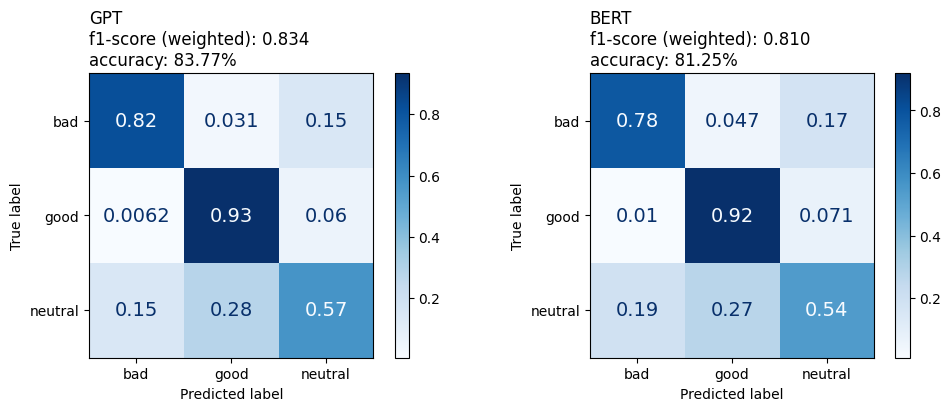

In [13]:
# Вывод результатов для каждой модели
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')
label='{}\nf1-score (weighted): {:.3f}\naccuracy: {:.2f}%'

for ax, model_name, result in zip(axs.flat, ['GPT', 'BERT'], [result_gpt, result_bert]):
    
    ax.set_title(
        loc='left',
        label=label.format(
            model_name,
            f1_score(y_true=result[1], y_pred=result[0].argmax(axis=1), average='weighted'),
            accuracy_score(y_true=result[1], y_pred=result[0].argmax(axis=1)) * 100
        )
    )
    ConfusionMatrixDisplay.from_predictions(
        y_true=pd.Series(result[1]).map(id2label), 
        y_pred=pd.Series(result[0].argmax(axis=1)).map(id2label),
        cmap='Blues',
        text_kw={'fontsize': 14},
        normalize='true',
        ax=ax
    )

* Обе получившиеся модели по способностям к классификации текстов справляются с задачай лучше, чем модели строящиеся на протяжении 6ти предыдущих Jupiter Notebook_ов. К примеру, лучшей моделью был Ансамбль из 10ти LSTM_CNN и его результаты были таковыми:
    - F1-score = 0.764
    - Accuracy = 76.41%
    - Матрица ошибок  
    
||bad|good|neutral|
|:-:|:-:|:-:|:-:|
|**bad**|0.77|0.064|0.17|
|**good**|0.025|0.86|0.11|
|**neutral**|0.23|0.3|0.47|
* Не смотря на то, что модель BERT содержит больше параметров,но справляется с задачей определения настроения отзыва хуже, чем модель GPT. Об этом свидетельствуют как основная метрика F1-score (weighted), так и второстепенная Accuracy. 
* Моделям всё так же трудно даётся определение отзывов с нейтральной окраской.

## Результаты

При помощи библиотеки Transformers:
* Были созданы LLM based классификаторы
* Загружены предварительно обученные веса параметров LLM основы
* Классификаторы были дообучены на имеющемся датасете для "подгонки" модели под нашу задачу